In [44]:
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, scale
from sklearn.cross_validation import train_test_split

import pandas as pd
from pickle import load, dump

from keras import metrics
import keras.backend as K
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.layers.merge import *
from keras.layers.convolutional import *
from keras.layers.embeddings import *
from keras.layers.wrappers import *
from keras.layers.normalization import *
from keras.layers.advanced_activations import *
from keras.models import *
from keras.callbacks import *
from keras.utils.vis_utils import *
from keras.utils import *

from IPython.display import SVG
import matplotlib.pyplot as plt

In [12]:
def read_data(path):
    Xs, Ys = pd.read_pickle(path)
    

    Xtrain, Xvalid, Xtest = Xs[:,:5725], Xs[:,5725:5725*2], Xs[:,5725*2:]
    
    Ys = np.concatenate([to_categorical(Ys[rowid])[None,:,:] for rowid in range(len(Ys))])
    Ytrain, Yvalid, Ytest = Ys[:,:5725], Ys[:,5725:5725*2], Ys[:,5725*2:]

    return Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest

In [42]:
Xtrain, Xvalid, Xtest, Ytrain, Yvalid, Ytest = read_data("../data/input.pkl")


In [43]:
print(f"train, X size: {Xtrain.shape}, Y size: {Ytrain.shape}")
print(f"test, X size: {Xvalid.shape}, Y size: {Yvalid.shape}")

train, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)
test, X size: (2, 5725, 100, 5), Y size: (2, 5725, 2)


In [53]:
scaler = StandardScaler()

In [55]:
Xtrain1 = scaler.fit_transform(Xtrain.reshape(-1, 500)).reshape(2, 5725, 100, 5)
Xvalid1 = scaler.transform(Xvalid.reshape(-1, 500)).reshape(2, 5725, 100, 5)

/home/wooya/.pyenv/versions/3.6.2/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Model definition

In [56]:
%%time 
# channel last
input_shape = (100, 5)
input = Input(shape=input_shape)

def block(input):
    nn = Conv1D(16, 3, padding='valid')(input)
    nn = BatchNormalization()(nn)
    nn = Activation("relu")(nn)
    nn = AveragePooling1D(5, strides=1, padding='valid')(nn)
    nn = Dropout(0.5)(nn)
    return nn

nn = input
for _ in range(5):
    nn = block(nn)

nn = Flatten()(nn)
# nn = Dense(625, activation="relu")(nn)
nn = Dense(32, activation="relu")(nn)
nn = Dense(2, activation="softmax")(nn)


clf = Model(inputs=input, outputs=nn)
clf.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 100, 5)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 98, 16)            256       
_________________________________________________________________
batch_normalization_30 (Batc (None, 98, 16)            64        
_________________________________________________________________
activation_30 (Activation)   (None, 98, 16)            0         
_________________________________________________________________
average_pooling1d_32 (Averag (None, 94, 16)            0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 94, 16)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 92, 16)            784       
__________

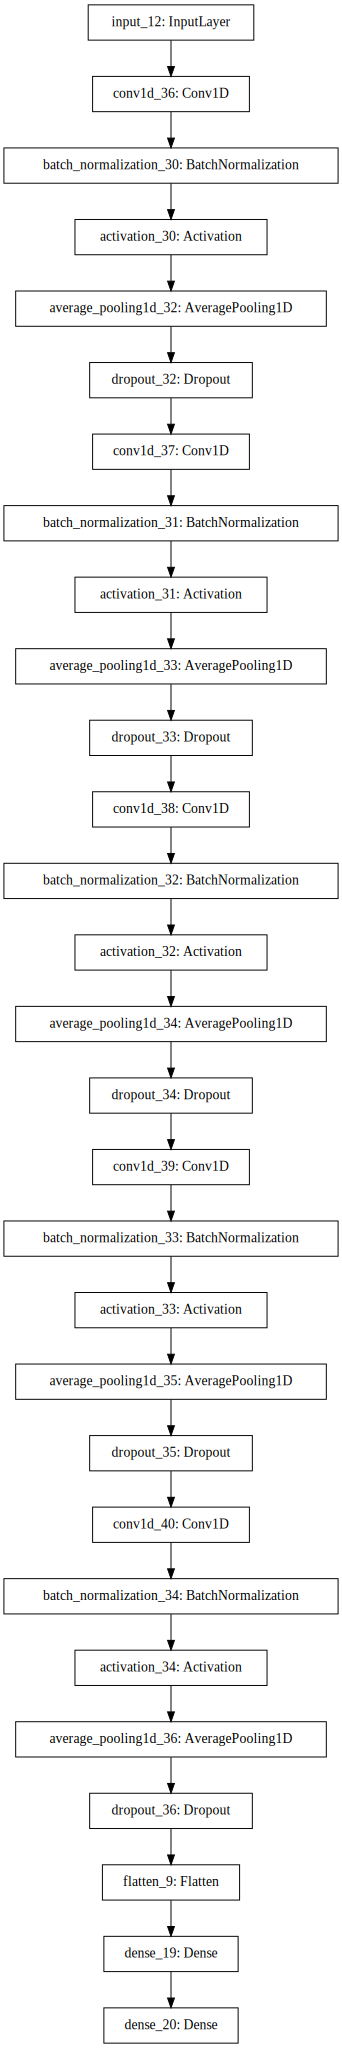

In [57]:
clf.summary()
SVG(model_to_dot(clf).create(prog='dot', format='svg'))

In [58]:
run_name = "deepchrome real new E013 scale 1"
tb = TensorBoard(log_dir=f"../log/{run_name}", batch_size=32, write_graph=True)
checkpointer = ModelCheckpoint(filepath=f"../model/{run_name}.h5", verbose=1, save_best_only=True, monitor="val_acc")
stopper = EarlyStopping(monitor="val_acc", patience=3)

In [ ]:
epigenome = 0
clf.fit(
    Xtrain1[epigenome],
    Ytrain[epigenome],
    batch_size=4000,
    callbacks = [tb, checkpointer],
    epochs=1000,
    shuffle=True,
    validation_data=(Xvalid1[epigenome], Yvalid[epigenome]),
    verbose=0)

Epoch 00000: val_acc improved from -inf to 0.47109, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.47109 to 0.55528, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00003: val_acc improved from 0.55528 to 0.65974, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00004: val_acc improved from 0.65974 to 0.66306, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.66306 to 0.67249, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00010: val_acc improved from 0.67249 to 0.73258, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 00011: val_acc improved from 0.73258 to 0.75249, saving model to ../model/deepchrome real new E013 scale 1.h5
Epoch 